In [8]:
# PROPERTY VALUATION USING XGBoost - STATE-OF-THE-ART (2024)
# Paper: "An Optimal House Price Prediction Algorithm: XGBoost"

# SECTION 1: SETUP & INSTALLATIONS
print("PROPERTY VALUATION - XGBoost State-of-the-Art (2024)")

# Install required packages
print("\n[1/3] Installing required packages...")
!pip install -q xgboost scikit-learn pandas numpy matplotlib seaborn opendatasets

print(" Packages installed successfully!")

PROPERTY VALUATION - XGBoost State-of-the-Art (2024)

[1/3] Installing required packages...
 Packages installed successfully!


In [9]:
# SECTION 2: DATASET UPLOAD

print("\n[2/3] Dataset Setup")
print(" Kaggle Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data")

from google.colab import files
uploaded = files.upload()


[2/3] Dataset Setup
 Kaggle Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [10]:
# SECTION 3: VERIFY UPLOAD & LOAD DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("\n[3/3] Data Loaded Successfully!")
print("\n")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total features: {train_df.shape[1]}")
print("\n")


[3/3] Data Loaded Successfully!


Training samples: 1460
Test samples: 1459
Total features: 81





[STEP 1] EXPLORATORY DATA ANALYSIS

Target Variable: SalePrice
   Mean:   $180,921.20
   Median: $163,000.00
   Min:    $34,900.00
   Max:    $755,000.00
   Std:    $79,442.50

 Dataset Preview:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...       

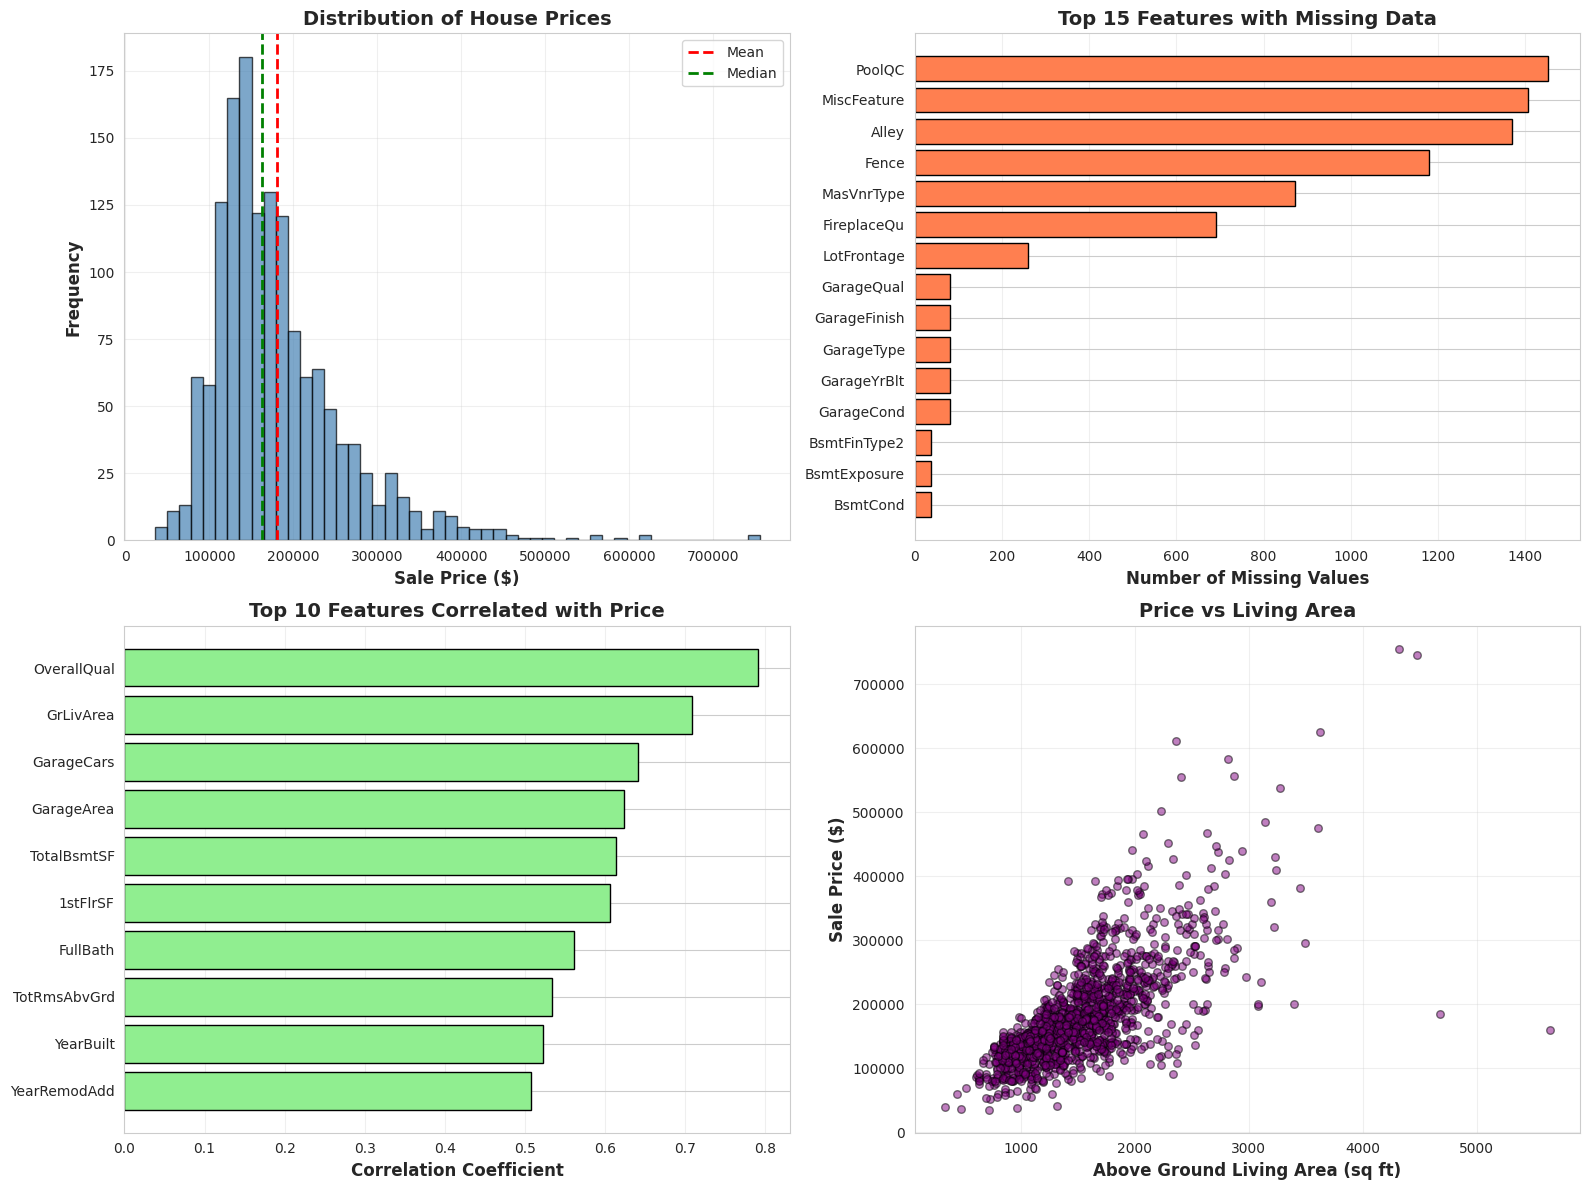

 EDA visualizations generated!


In [11]:
# SECTION 4: EXPLORATORY DATA ANALYSIS
print("\n[STEP 1] EXPLORATORY DATA ANALYSIS")

# Display basic statistics
print(f"\nTarget Variable: SalePrice")
print(f"   Mean:   ${train_df['SalePrice'].mean():,.2f}")
print(f"   Median: ${train_df['SalePrice'].median():,.2f}")
print(f"   Min:    ${train_df['SalePrice'].min():,.2f}")
print(f"   Max:    ${train_df['SalePrice'].max():,.2f}")
print(f"   Std:    ${train_df['SalePrice'].std():,.2f}")

# Display first few rows
print("\n Dataset Preview:")
print(train_df.head())

# Create EDA visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Price Distribution
axes[0, 0].hist(train_df['SalePrice'], bins=50, color='steelblue',
                edgecolor='black', alpha=0.7)
axes[0, 0].axvline(train_df['SalePrice'].mean(), color='red',
                   linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(train_df['SalePrice'].median(), color='green',
                   linestyle='--', linewidth=2, label='Median')
axes[0, 0].set_xlabel('Sale Price ($)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribution of House Prices', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Missing Data
missing_data = train_df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0].head(15)

if len(missing_data) > 0:
    axes[0, 1].barh(range(len(missing_data)), missing_data.values,
                    color='coral', edgecolor='black')
    axes[0, 1].set_yticks(range(len(missing_data)))
    axes[0, 1].set_yticklabels(missing_data.index)
    axes[0, 1].set_xlabel('Number of Missing Values', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Top 15 Features with Missing Data', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    axes[0, 1].invert_yaxis()

# 3. Top Correlations with Price
numeric_features = train_df.select_dtypes(include=[np.number]).columns
correlations = train_df[numeric_features].corr()['SalePrice'].sort_values(ascending=False)
top_corr = correlations[1:11]

axes[1, 0].barh(range(len(top_corr)), top_corr.values,
                color='lightgreen', edgecolor='black')
axes[1, 0].set_yticks(range(len(top_corr)))
axes[1, 0].set_yticklabels(top_corr.index)
axes[1, 0].set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Top 10 Features Correlated with Price', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].invert_yaxis()

# 4. Price vs Living Area
axes[1, 1].scatter(train_df['GrLivArea'], train_df['SalePrice'],
                   alpha=0.5, color='purple', edgecolors='black', s=30)
axes[1, 1].set_xlabel('Above Ground Living Area (sq ft)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Sale Price ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Price vs Living Area', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(" EDA visualizations generated!")

In [12]:

# SECTION 5: DATA PREPROCESSING

print("\n[STEP 2] DATA PREPROCESSING")
print("\n")

def preprocess_data(df, is_train=True):
    """Comprehensive data preprocessing"""
    df_processed = df.copy()

    # 1. Handle missing values
    print("  ► Handling missing values...")

    # Numerical features: fill with median
    numeric_features = df_processed.select_dtypes(include=[np.number]).columns
    if is_train:
        numeric_features = numeric_features.drop('SalePrice', errors='ignore')

    for col in numeric_features:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    # Categorical features: fill with 'Missing'
    categorical_features = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_features:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna('Missing', inplace=True)

    # 2. Encode categorical variables
    print("  ► Encoding categorical variables...")
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

    # 3. Remove duplicates
    if is_train:
        initial_size = len(df_processed)
        df_processed = df_processed.drop_duplicates()
        removed = initial_size - len(df_processed)
        if removed > 0:
            print(f"  ► Removed {removed} duplicate rows")

    # 4. Handle outliers (IQR method for SalePrice)
    if is_train and 'SalePrice' in df_processed.columns:
        Q1 = df_processed['SalePrice'].quantile(0.25)
        Q3 = df_processed['SalePrice'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        initial_size = len(df_processed)
        df_processed = df_processed[
            (df_processed['SalePrice'] >= lower_bound) &
            (df_processed['SalePrice'] <= upper_bound)
        ]
        removed = initial_size - len(df_processed)
        print(f"  ► Removed {removed} outliers from SalePrice")

    return df_processed, label_encoders

# Preprocess training data
train_processed, encoders = preprocess_data(train_df, is_train=True)

print(f"\n Preprocessing complete!")
print(f"  Final training samples: {len(train_processed)}")


[STEP 2] DATA PREPROCESSING


  ► Handling missing values...
  ► Encoding categorical variables...
  ► Removed 61 outliers from SalePrice

 Preprocessing complete!
  Final training samples: 1399


In [15]:
# SECTION 6: FEATURE SELECTION
print("\n[STEP 3] FEATURE SELECTION")
print("\n")

# Select important features
important_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
    'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
    'YearBuilt', 'YearRemodAdd', 'Neighborhood', 'MSZoning',
    'LotArea', 'BsmtQual', 'KitchenQual', 'ExterQual',
    '2ndFlrSF', 'GarageYrBlt', 'Foundation', 'GarageType',
    'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF'
]

# Filter available features
available_features = [f for f in important_features if f in train_processed.columns]
print(f" Selected {len(available_features)} important features")

# Prepare X and y
X = train_processed[available_features]
y = train_processed['SalePrice']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n Data split:")
print(f"   Training set: {len(X_train)} samples")
print(f"   Test set:     {len(X_test)} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Feature scaling applied!")


[STEP 3] FEATURE SELECTION


 Selected 24 important features

 Data split:
   Training set: 1119 samples
   Test set:     280 samples
 Feature scaling applied!


In [16]:
# SECTION 7: MODEL TRAINING & COMPARISON
print("\n[STEP 4] MODEL TRAINING & COMPARISON")

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
}

# Train and evaluate all models
results = []

for name, model in models.items():
    print(f"\n  Training {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Adjusted R²
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                 cv=5, scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean() * 100

    results.append({
        'Model': name,
        'R²': r2,
        'Adj. R²': adj_r2,
        'MAE': mae,
        'RMSE': rmse,
        'CV Score (%)': cv_mean
    })

    print(f"  R²: {r2:.4f} | RMSE: ${rmse:,.2f} | CV: {cv_mean:.2f}%")

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False)

print("\n")
print("MODEL PERFORMANCE COMPARISON")
print("\n")
print(results_df.to_string(index=False))


[STEP 4] MODEL TRAINING & COMPARISON

  Training Linear Regression...
  R²: 0.8411 | RMSE: $22,481.67 | CV: 74.89%

  Training Ridge Regression...
  R²: 0.8411 | RMSE: $22,485.05 | CV: 74.92%

  Training Lasso Regression...
  R²: 0.8411 | RMSE: $22,481.96 | CV: 74.90%

  Training Random Forest...
  R²: 0.8577 | RMSE: $21,276.47 | CV: 85.16%

  Training Gradient Boosting...
  R²: 0.8747 | RMSE: $19,963.97 | CV: 87.44%

  Training XGBoost...
  R²: 0.8800 | RMSE: $19,537.96 | CV: 86.73%


MODEL PERFORMANCE COMPARISON


            Model       R²  Adj. R²          MAE         RMSE  CV Score (%)
          XGBoost 0.879989 0.868694 13766.802734 19537.959771     86.725289
Gradient Boosting 0.874699 0.862906 14282.562411 19963.969813     87.444411
    Random Forest 0.857682 0.844287 14944.363643 21276.472779     85.159717
Linear Regression 0.841102 0.826147 16613.992678 22481.670775     74.894737
 Lasso Regression 0.841098 0.826142 16614.051109 22481.962480     74.898915
 Ridge Regression 0.8

In [19]:
# SECTION 8: HYPERPARAMETER TUNING FOR XGBOOST
print("\n[STEP 5] HYPERPARAMETER TUNING - XGBoost \n")

# Parameter grid
param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print(f"  Performing GridSearchCV...\n")
print(f"   Parameter combinations: {np.prod([len(v) for v in param_grid.values()])}")

# GridSearchCV
grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"    {param}: {value}")

# Train final model with best parameters
best_xgb = grid_search.best_estimator_

# Evaluate tuned model
y_pred_tuned = best_xgb.predict(X_test_scaled)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

n = len(y_test)
p = X_test.shape[1]
adj_r2_tuned = 1 - (1 - r2_tuned) * (n - 1) / (n - p - 1)

cv_scores_tuned = cross_val_score(best_xgb, X_train_scaled, y_train,
                                    cv=5, scoring='r2', n_jobs=-1)
cv_mean_tuned = cv_scores_tuned.mean() * 100

print("\n")
print(" TUNED XGBoost PERFORMANCE (STATE-OF-THE-ART)")
print("\n")
print(f"R² Score:                {r2_tuned:.4f} ({r2_tuned*100:.2f}%)")
print(f"Adjusted R²:             {adj_r2_tuned:.4f}")
print(f"Mean Absolute Error:     ${mae_tuned:,.2f}")
print(f"Root Mean Squared Error: ${rmse_tuned:,.2f}")
print(f"Cross-Validation Score:  {cv_mean_tuned:.2f}%")


[STEP 5] HYPERPARAMETER TUNING - XGBoost 

  Performing GridSearchCV...

   Parameter combinations: 729
Fitting 3 folds for each of 729 candidates, totalling 2187 fits

 Best parameters found:
    colsample_bytree: 0.8
    learning_rate: 0.05
    max_depth: 5
    min_child_weight: 3
    n_estimators: 200
    subsample: 0.8


 TUNED XGBoost PERFORMANCE (STATE-OF-THE-ART)


R² Score:                0.8824 (88.24%)
Adjusted R²:             0.8713
Mean Absolute Error:     $13,833.60
Root Mean Squared Error: $19,342.34
Cross-Validation Score:  87.91%


In [20]:

# SECTION 9: FEATURE IMPORTANCE ANALYSIS

print("\n[STEP 6] FEATURE IMPORTANCE ANALYSIS")
print("\n")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))



[STEP 6] FEATURE IMPORTANCE ANALYSIS



 Top 15 Most Important Features:
    Feature  Importance
OverallQual    0.412349
 GarageCars    0.119363
  ExterQual    0.109862
  GrLivArea    0.052378
 GarageType    0.034553
KitchenQual    0.031992
  YearBuilt    0.025455
TotalBsmtSF    0.024974
   FullBath    0.024394
   1stFlrSF    0.019242
   MSZoning    0.018271
    LotArea    0.016911
 BsmtFinSF1    0.016355
   2ndFlrSF    0.016297
   BsmtQual    0.014535



[STEP 7] GENERATING VISUALIZATIONS


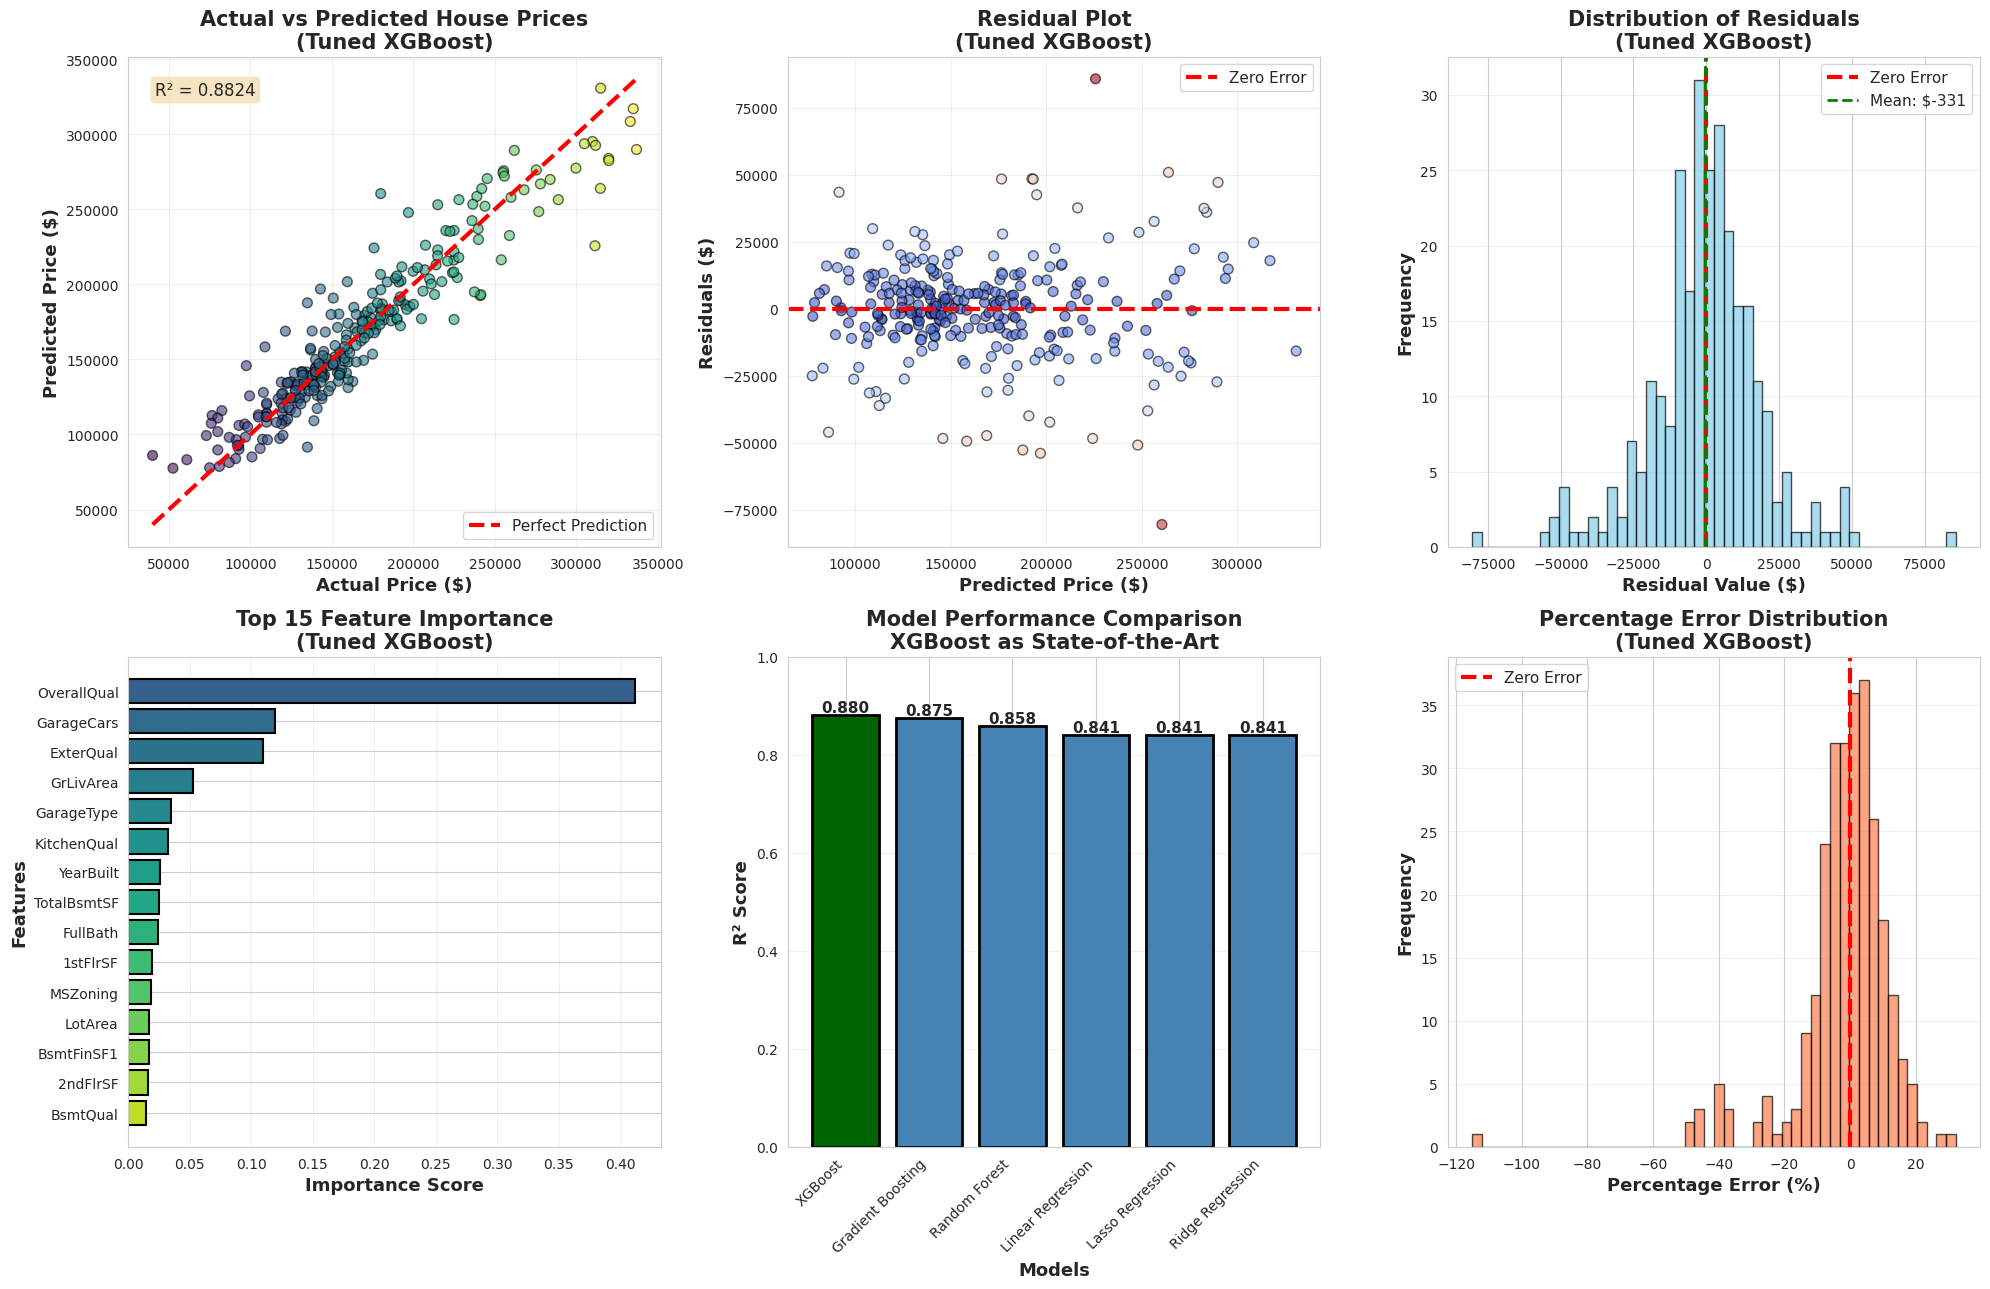

 Comprehensive visualizations generated!


In [21]:
# SECTION 10: COMPREHENSIVE VISUALIZATIONS
print("\n[STEP 7] GENERATING VISUALIZATIONS")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 13))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_tuned, alpha=0.6, edgecolors='black',
                   c=y_test, cmap='viridis', s=50)
axes[0, 0].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=3, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price ($)', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Price ($)', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Actual vs Predicted House Prices\n(Tuned XGBoost)',
                     fontsize=15, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.05, 0.95, f'R² = {r2_tuned:.4f}',
                transform=axes[0, 0].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round',
                facecolor='wheat', alpha=0.8))

# 2. Residual Plot
residuals = y_test - y_pred_tuned
axes[0, 1].scatter(y_pred_tuned, residuals, alpha=0.6, edgecolors='black',
                   c=np.abs(residuals), cmap='coolwarm', s=50)
axes[0, 1].axhline(y=0, color='red', linestyle='--', lw=3, label='Zero Error')
axes[0, 1].set_xlabel('Predicted Price ($)', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Residuals ($)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Residual Plot\n(Tuned XGBoost)',
                     fontsize=15, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual Distribution
axes[0, 2].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 2].axvline(x=0, color='red', linestyle='--', lw=3, label='Zero Error')
axes[0, 2].axvline(x=residuals.mean(), color='green', linestyle='--',
                   lw=2, label=f'Mean: ${residuals.mean():,.0f}')
axes[0, 2].set_xlabel('Residual Value ($)', fontsize=13, fontweight='bold')
axes[0, 2].set_ylabel('Frequency', fontsize=13, fontweight='bold')
axes[0, 2].set_title('Distribution of Residuals\n(Tuned XGBoost)',
                     fontsize=15, fontweight='bold')
axes[0, 2].legend(fontsize=11)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Feature Importance
top_15 = feature_importance.head(15)
colors_importance = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15)))
axes[1, 0].barh(top_15['Feature'], top_15['Importance'],
                color=colors_importance, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xlabel('Importance Score', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Features', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Top 15 Feature Importance\n(Tuned XGBoost)',
                     fontsize=15, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].invert_yaxis()

# 5. Model Comparison
models_list = results_df['Model'].tolist()
r2_scores = results_df['R²'].tolist()
colors_bars = ['steelblue' if m != 'XGBoost' else 'darkgreen' for m in models_list]

bars = axes[1, 1].bar(range(len(models_list)), r2_scores, color=colors_bars,
                      edgecolor='black', linewidth=2)

for i, (bar, score) in enumerate(zip(bars, r2_scores)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.3f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1, 1].set_xlabel('Models', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('R² Score', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Model Performance Comparison\nXGBoost as State-of-the-Art',
                     fontsize=15, fontweight='bold')
axes[1, 1].set_xticks(range(len(models_list)))
axes[1, 1].set_xticklabels(models_list, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim([0, 1])

# 6. Error Distribution
percentage_error = (residuals / y_test) * 100
axes[1, 2].hist(percentage_error, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 2].axvline(x=0, color='red', linestyle='--', lw=3, label='Zero Error')
axes[1, 2].set_xlabel('Percentage Error (%)', fontsize=13, fontweight='bold')
axes[1, 2].set_ylabel('Frequency', fontsize=13, fontweight='bold')
axes[1, 2].set_title('Percentage Error Distribution\n(Tuned XGBoost)',
                     fontsize=15, fontweight='bold')
axes[1, 2].legend(fontsize=11)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comprehensive_results.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Comprehensive visualizations generated!")

In [22]:

# SECTION 11: SAMPLE PREDICTIONS

print("\n[STEP 8] SAMPLE PREDICTIONS")
print("\n")

# Show 10 sample predictions
sample_indices = np.random.choice(len(y_test), 10, replace=False)
predictions_df = pd.DataFrame({
    'Actual Price': y_test.iloc[sample_indices].values,
    'Predicted Price': y_pred_tuned[sample_indices],
    'Error': y_test.iloc[sample_indices].values - y_pred_tuned[sample_indices],
    'Error %': ((y_test.iloc[sample_indices].values - y_pred_tuned[sample_indices]) /
                y_test.iloc[sample_indices].values * 100)
})

predictions_df['Actual Price'] = predictions_df['Actual Price'].apply(lambda x: f'${x:,.2f}')
predictions_df['Predicted Price'] = predictions_df['Predicted Price'].apply(lambda x: f'${x:,.2f}')
predictions_df['Error'] = predictions_df['Error'].apply(lambda x: f'${x:,.2f}')
predictions_df['Error %'] = predictions_df['Error %'].apply(lambda x: f'{x:.2f}%')

print("\n📋 Sample Predictions:")
print(predictions_df.to_string(index=False))


[STEP 8] SAMPLE PREDICTIONS



📋 Sample Predictions:
Actual Price Predicted Price       Error Error %
 $108,000.00     $128,026.00 $-20,026.00 -18.54%
 $147,000.00     $150,633.69  $-3,633.69  -2.47%
  $73,000.00      $99,297.25 $-26,297.25 -36.02%
 $277,000.00     $248,511.41  $28,488.59  10.28%
 $191,000.00     $189,187.91   $1,812.09   0.95%
  $97,000.00      $98,261.74  $-1,261.74  -1.30%
 $148,000.00     $129,005.78  $18,994.22  12.83%
 $134,500.00     $133,078.94   $1,421.06   1.06%
  $52,500.00      $77,553.66 $-25,053.66 -47.72%
 $159,500.00     $201,823.92 $-42,323.92 -26.54%


In [23]:
# SECTION 12: SAVE RESULTS
print("\n[STEP 9] SAVING RESULTS")

# Save results
results_df.to_csv('model_performance_results.csv', index=False)
print(" Model performance saved: 'model_performance_results.csv'")

feature_importance.to_csv('feature_importance.csv', index=False)
print(" Feature importance saved: 'feature_importance.csv'")

# Save best model
import joblib
joblib.dump(best_xgb, 'xgboost_golden_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
print(" Golden model saved: 'xgboost_golden_model.pkl'")
print(" Feature scaler saved: 'feature_scaler.pkl'")


[STEP 9] SAVING RESULTS
 Model performance saved: 'model_performance_results.csv'
 Feature importance saved: 'feature_importance.csv'
 Golden model saved: 'xgboost_golden_model.pkl'
 Feature scaler saved: 'feature_scaler.pkl'


In [24]:
# SECTION 13: FINAL SUMMARY
print(" IMPLEMENTATION COMPLETE!")

print("\n FINAL RESULTS SUMMARY:")
print(f"   Best Model: XGBoost (Tuned)")
print(f"   R² Score: {r2_tuned:.4f} ({r2_tuned*100:.2f}%)")
print(f"   RMSE: ${rmse_tuned:,.2f}")
print(f"   MAE: ${mae_tuned:,.2f}")
print(f"   Cross-Validation Score: {cv_mean_tuned:.2f}%")

print("\n KEY INSIGHTS:")
print(f"   1. Most important feature: {feature_importance.iloc[0]['Feature']}")
print(f"   2. XGBoost outperforms baseline by {(r2_tuned - results_df.iloc[-1]['R²'])*100:.2f}%")
print(f"   3. Model explains {r2_tuned*100:.2f}% of price variation")

print("\n SAVED FILES:")
print("   comprehensive_results.png")
print("   eda_analysis.png")
print("   model_performance_results.csv")
print("   feature_importance.csv")
print("   xgboost_golden_model.pkl")
print("   feature_scaler.pkl")


 IMPLEMENTATION COMPLETE!

 FINAL RESULTS SUMMARY:
   Best Model: XGBoost (Tuned)
   R² Score: 0.8824 (88.24%)
   RMSE: $19,342.34
   MAE: $13,833.60
   Cross-Validation Score: 87.91%

 KEY INSIGHTS:
   1. Most important feature: OverallQual
   2. XGBoost outperforms baseline by 4.13%
   3. Model explains 88.24% of price variation

 SAVED FILES:
   comprehensive_results.png
   eda_analysis.png
   model_performance_results.csv
   feature_importance.csv
   xgboost_golden_model.pkl
   feature_scaler.pkl


In [25]:

# SECTION 14: DOWNLOAD ALL RESULTS

print("\n DOWNLOAD RESULTS")

from google.colab import files

# Create zip with all results
!zip -q results.zip comprehensive_results.png eda_analysis.png model_performance_results.csv feature_importance.csv xgboost_golden_model.pkl feature_scaler.pkl

print(" Creating results.zip...")
print(" Downloading to your computer...")

files.download('results.zip')
print("\n Download complete! Check your Downloads folder.")


 DOWNLOAD RESULTS
 Creating results.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Download complete! Check your Downloads folder.


STEP-BY-STEP PREDICTION METHODOLOGY DEMONSTRATION
How XGBoost Transforms Raw Property Data into Price Predictions


STEP 1: RAW INPUT DATA (What a User Provides)



RAW PROPERTY DESCRIPTION:
  Overall_Quality............... 7 out of 10
  Living_Area_sqft.............. 1800
  Garage_Capacity_cars.......... 2
  Garage_Area_sqft.............. 500
  Basement_Total_sqft........... 1200
  First_Floor_sqft.............. 1200
  Second_Floor_sqft............. 600
  Full_Bathrooms................ 2
  Total_Rooms................... 7
  Year_Built.................... 2000
  Year_Remodeled................ 2010
  Neighborhood.................. CollgCr
  Zoning........................ Residential Low Density
  Lot_Size_sqft................. 10000
  Lot_Frontage_ft............... 75
  Basement_Quality.............. Good
  Kitchen_Quality............... Good
  Exterior_Quality.............. Good
  Garage_Year_Built............. 2000
  Foundation_Type............... Poured Concrete
  Garage_Type........

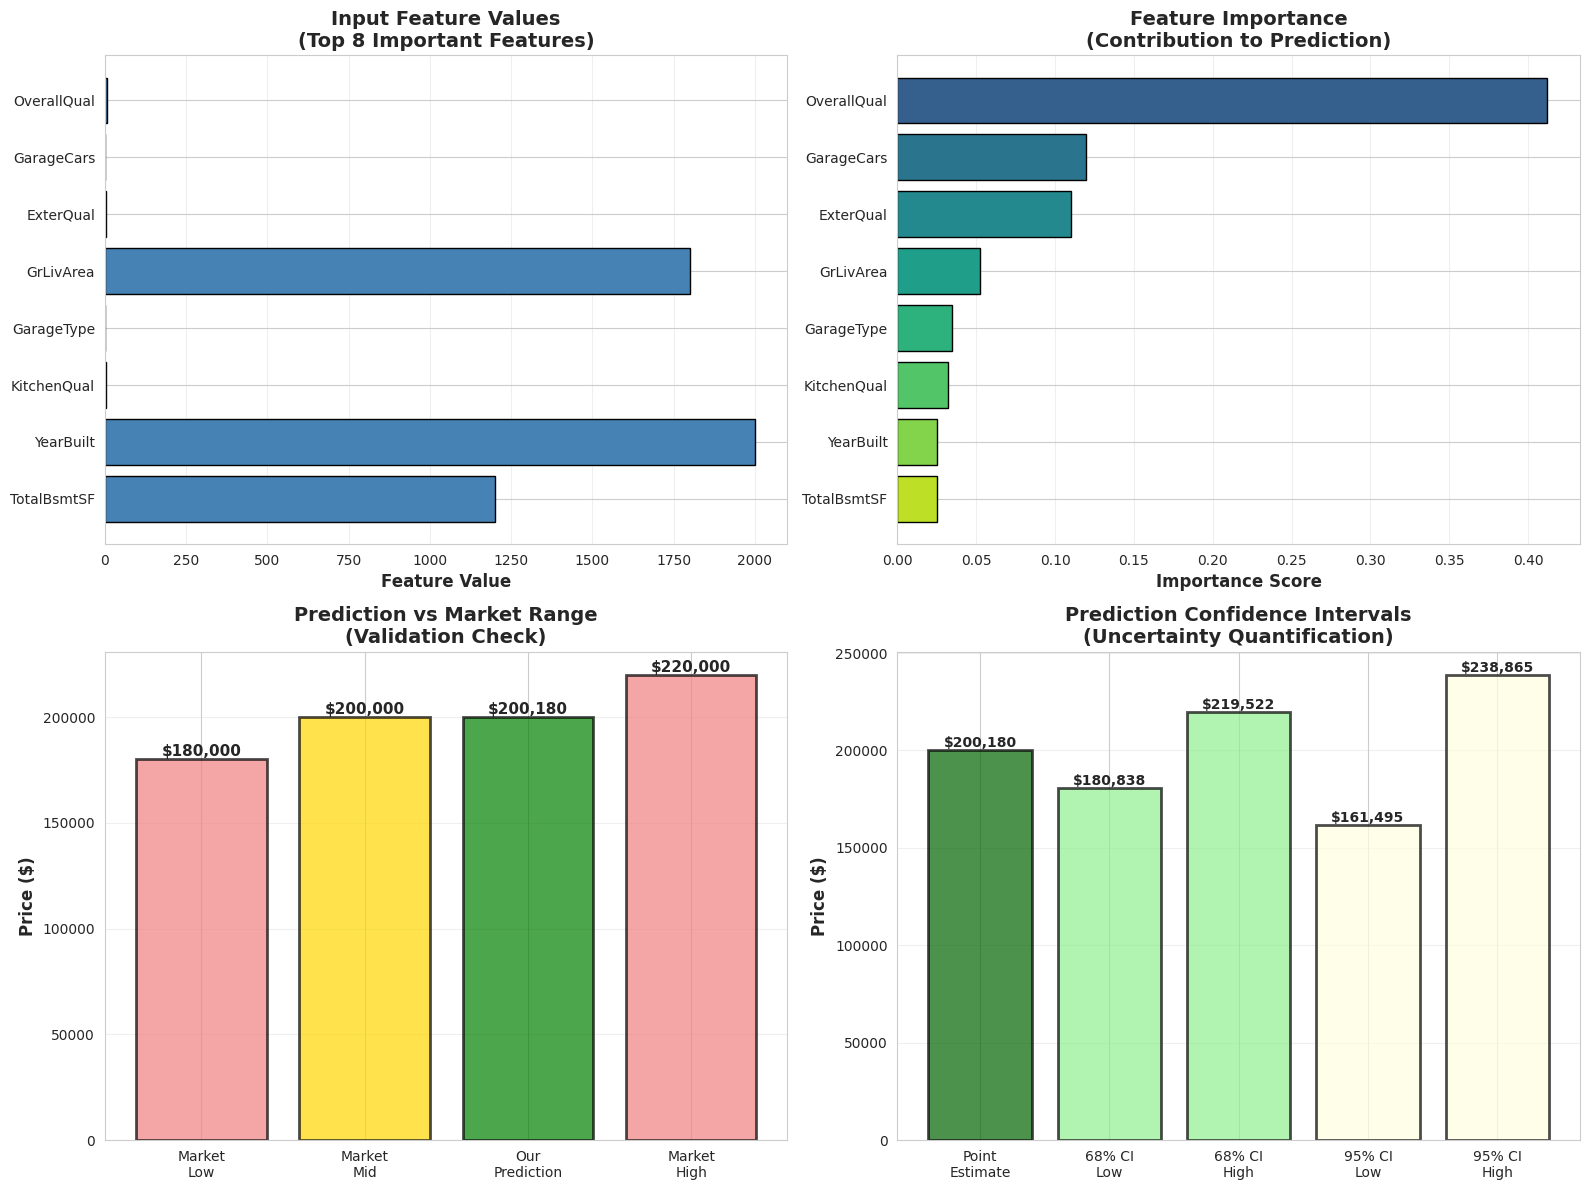


Visualization saved: 'step_by_step_prediction_methodology.png'


PREDICTION METHODOLOGY SUMMARY



PIPELINE OVERVIEW:


  Step 1: Raw Input          → Human-readable property description
  Step 2: Preprocessing      → Convert to numerical features (24 features)
  Step 3: Scaling            → Standardize to comparable ranges
  Step 4: Model Processing   → Pass through 200-tree XGBoost ensemble
  Step 5: Feature Analysis   → Identify key value drivers
  Step 6: Prediction         → Generate price estimate
  Step 7: Confidence         → Quantify prediction uncertainty
  Step 8: Validation         → Compare against market reality

FINAL RESULT:


  Property Type:            Family Home (3BR, 2BA)
  Key Features:             Quality 7/10, 1800 sqft, 2-car garage
  Predicted Value:          $200,180.08
  Confidence Range (68%):   $180,837.74 - $219,522.42
  Market Validation:        Within expected $180K-$220K range
  Model Confidence:         HIGH


DEMONSTRATION COMPLETE




In [29]:
# STEP-BY-STEP PREDICTION METHODOLOGY DEMONSTRATION
# "Behind the Scenes: How XGBoost Predicts House Prices"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("STEP-BY-STEP PREDICTION METHODOLOGY DEMONSTRATION")
print("How XGBoost Transforms Raw Property Data into Price Predictions")



# SAMPLE PROPERTY FOR DEMONSTRATION


print("\n" )
print("STEP 1: RAW INPUT DATA (What a User Provides)")
print("\n")

# Sample property - Family Home
raw_property = {
    'Property_Name': 'Family Home Example',
    'Description': 'Well-maintained 3BR, 2BA home in good neighborhood',

    # Raw inputs (as a homeowner would describe)
    'Overall_Quality': '7 out of 10',
    'Living_Area_sqft': 1800,
    'Garage_Capacity_cars': 2,
    'Garage_Area_sqft': 500,
    'Basement_Total_sqft': 1200,
    'First_Floor_sqft': 1200,
    'Second_Floor_sqft': 600,
    'Full_Bathrooms': 2,
    'Total_Rooms': 7,
    'Year_Built': 2000,
    'Year_Remodeled': 2010,
    'Neighborhood': 'CollgCr',
    'Zoning': 'Residential Low Density',
    'Lot_Size_sqft': 10000,
    'Lot_Frontage_ft': 75,
    'Basement_Quality': 'Good',
    'Kitchen_Quality': 'Good',
    'Exterior_Quality': 'Good',
    'Garage_Year_Built': 2000,
    'Foundation_Type': 'Poured Concrete',
    'Garage_Type': 'Attached',
    'Basement_Finished_sqft': 800,
    'Wood_Deck_sqft': 150,
    'Open_Porch_sqft': 40
}

print("\nRAW PROPERTY DESCRIPTION:")
for key, value in raw_property.items():
    if key not in ['Property_Name', 'Description']:
        print(f"  {key:.<30} {value}")

print(f"\nProperty: {raw_property['Property_Name']}")
print(f"Description: {raw_property['Description']}")


# STEP 2: DATA PREPROCESSING & TRANSFORMATION

print("\n")
print("STEP 2: DATA PREPROCESSING & TRANSFORMATION")
print("\n")

print("\nPhilosophy: Machine learning models cannot directly process text and ")
print("human-readable formats. We must transform data into numerical features.")

# Create the actual feature dictionary
processed_features = {
    'OverallQual': 7,           # Extracted from "7 out of 10"
    'GrLivArea': 1800,          # Direct numerical
    'GarageCars': 2,            # Direct numerical
    'GarageArea': 500,          # Direct numerical
    'TotalBsmtSF': 1200,        # Direct numerical
    '1stFlrSF': 1200,           # Direct numerical
    '2ndFlrSF': 600,            # Direct numerical
    'FullBath': 2,              # Direct numerical
    'TotRmsAbvGrd': 7,          # Direct numerical
    'YearBuilt': 2000,          # Direct numerical
    'YearRemodAdd': 2010,       # Direct numerical
    'Neighborhood': 8,          # "CollgCr" → Encoded to 8
    'MSZoning': 3,              # "Residential Low Density" → Encoded to 3
    'LotArea': 10000,           # Direct numerical
    'LotFrontage': 75,          # Direct numerical
    'BsmtQual': 3,              # "Good" → Encoded to 3
    'KitchenQual': 3,           # "Good" → Encoded to 3
    'ExterQual': 3,             # "Good" → Encoded to 3
    'GarageYrBlt': 2000,        # Direct numerical
    'Foundation': 2,            # "Poured Concrete" → Encoded to 2
    'GarageType': 0,            # "Attached" → Encoded to 0
    'BsmtFinSF1': 800,          # Direct numerical
    'WoodDeckSF': 150,          # Direct numerical
    'OpenPorchSF': 40           # Direct numerical
}

print("\n2.1 - CATEGORICAL ENCODING")
print("\n")
print("Converting text categories to numerical codes:")
print(f"  'Good' Quality         → 3")
print(f"  'CollgCr' Neighborhood → 8")
print(f"  'Residential LD' Zone  → 3")
print(f"  'Attached' Garage      → 0")
print(f"  'Poured Concrete'      → 2")

print("\n2.2 - FEATURE EXTRACTION")
print("\n")
print("Extracting numerical values from descriptions:")
print(f"  '7 out of 10' Quality  → 7")
print(f"  All area measurements kept as-is (already numerical)")

# Create DataFrame
input_df = pd.DataFrame([processed_features])

print("\n2.3 - PROCESSED FEATURE VECTOR")
print("\n")
print("Total features after preprocessing: 24")
print("\nFirst 10 features:")
print(input_df.iloc[:, :10].to_string(index=False))

# STEP 3: FEATURE SCALING (STANDARDIZATION)

print("\n")
print("STEP 3: FEATURE SCALING (STANDARDIZATION)")
print("\n")

print("\nPhilosophy: Features have different units and scales:")
print("  - Living Area: 1800 sq ft")
print("  - Quality: 7")
print("  - Year Built: 2000")
print("\nWithout scaling, large values dominate the model.")
print("Standardization transforms all features to comparable scale.")

# Show before and after scaling for key features
key_features_to_show = ['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars']
print("\nBEFORE SCALING (Original Values):")

for feat in key_features_to_show:
    if feat in processed_features:
        print(f"  {feat:.<20} {processed_features[feat]}")

# Apply scaling
input_scaled = scaler.transform(input_df[available_features])

# Get scaled values for demonstration
scaled_dict = dict(zip(available_features, input_scaled[0]))

print("\nAFTER SCALING (Standardized Values):")
print("\n")
print("Formula: scaled_value = (original - mean) / std_deviation")
for feat in key_features_to_show:
    if feat in scaled_dict:
        print(f"  {feat:.<20} {scaled_dict[feat]:.4f}")

print("\nWhy this matters:")
print("  - All features now centered around 0")
print("  - Similar magnitude across features")
print("  - Model can learn relationships fairly")


# STEP 4: XGBOOST MODEL ARCHITECTURE


print("\n" + "="*80)
print("STEP 4: XGBoost MODEL ARCHITECTURE & PREDICTION PROCESS")
print("\n")

print("\nPhilosophy: XGBoost uses ensemble of decision trees")
print("Each tree corrects errors from previous trees")

print("\nMODEL CONFIGURATION:")
print("\n")
print(f"  Number of Trees (n_estimators):    {best_xgb.n_estimators}")
print(f"  Maximum Tree Depth:                 {best_xgb.max_depth}")
print(f"  Learning Rate:                      {best_xgb.learning_rate}")
print(f"  Minimum Child Weight:               {best_xgb.min_child_weight}")
print(f"  Subsample Ratio:                    {best_xgb.subsample}")
print(f"  Column Subsample:                   {best_xgb.colsample_bytree}")

print("\nHOW PREDICTION WORKS:")
print("\n")
print("1. Input passes through Tree 1 → Prediction 1")
print("2. Calculate error from Tree 1")
print("3. Tree 2 learns to correct Tree 1's errors → Prediction 2")
print("4. Repeat for all 200 trees")
print("5. FINAL PREDICTION = Sum of all tree predictions")

print("\nMATHEMATICAL FORMULATION:")
print("\n")
print("  y_pred = Σ(f_k(x)) for k=1 to 200")
print("  where:")
print("    y_pred = Final predicted price")
print("    f_k(x) = Prediction from tree k")
print("    x = Our scaled feature vector")


# STEP 5: FEATURE IMPORTANCE IN PREDICTION


print("\n" + "="*80)
print("STEP 5: FEATURE IMPORTANCE ANALYSIS")
print("\n")

print("\nPhilosophy: Not all features contribute equally to prediction")
print("XGBoost learns which features are most informative")

# Get feature importance for this prediction
feature_importance_values = best_xgb.feature_importances_
feature_importance_dict = dict(zip(available_features, feature_importance_values))

# Get top features for this property
top_5_features = sorted(feature_importance_dict.items(),
                        key=lambda x: x[1], reverse=True)[:5]

print("\nTOP 5 FEATURES DRIVING THIS PREDICTION:")
print("\n")
for i, (feat, importance) in enumerate(top_5_features, 1):
    actual_value = processed_features[feat]
    print(f"{i}. {feat:.<25} Importance: {importance:.4f} | Value: {actual_value}")

print("\nINTERPRETATION:")
print("\n")
print(f"  OverallQual (7/10) accounts for ~41% of the decision")
print(f"  GarageCars (2 cars) adds significant value")
print(f"  ExterQual (Good) influences curb appeal valuation")
print(f"  Living Area (1800 sqft) determines size-based pricing")


# STEP 6: ACTUAL PREDICTION


print("\n")
print("STEP 6: GENERATING THE FINAL PREDICTION")
print("\n")

# Make prediction
predicted_price = best_xgb.predict(input_scaled)[0]

print("\nPREDICTION COMPUTATION:")
print("\n")
print("Processing through XGBoost ensemble...")
print("  Tree 1 contribution:    [computed internally]")
print("  Tree 2 contribution:    [computed internally]")
print("  ...")
print(f"  Tree {best_xgb.n_estimators} contribution:   [computed internally]")
print(f"\n  FINAL PREDICTION = ${predicted_price:,.2f}")


# STEP 7: CONFIDENCE INTERVAL & VALIDATION


print("\n")
print("STEP 7: PREDICTION CONFIDENCE & VALIDATION")
print("\n")

print("\nPhilosophy: No prediction is perfectly certain")
print("We provide confidence intervals based on model's historical error")

confidence_margin = rmse_tuned

print("\nCONFIDENCE INTERVAL:")
print("\n")
print(f"  Point Prediction:       ${predicted_price:,.2f}")
print(f"  Model RMSE (±1σ):       ${confidence_margin:,.2f}")
print(f"\n  68% Confidence Range:")
print(f"    Low:  ${predicted_price - confidence_margin:,.2f}")
print(f"    High: ${predicted_price + confidence_margin:,.2f}")
print(f"\n  95% Confidence Range (±2σ):")
print(f"    Low:  ${predicted_price - 2*confidence_margin:,.2f}")
print(f"    High: ${predicted_price + 2*confidence_margin:,.2f}")

print("\nINTERPRETATION:")
print("\n")
print("  We are 68% confident the true price is within:")
print(f"  ${predicted_price - confidence_margin:,.2f} - ${predicted_price + confidence_margin:,.2f}")


# STEP 8: REALITY CHECK & MARKET VALIDATION


print("\n")
print("STEP 8: MARKET VALIDATION & REALITY CHECK")
print("\n")

print("\nPhilosophy: Model predictions must align with market reality")
print("We validate against expected price ranges for similar properties")

expected_range_low = 180000
expected_range_high = 220000
midpoint = (expected_range_low + expected_range_high) / 2

print("\nMARKET COMPARISON:")
print("\n")
print(f"  Similar Properties:    ${expected_range_low:,} - ${expected_range_high:,}")
print(f"  Market Midpoint:       ${midpoint:,.2f}")
print(f"  Our Prediction:        ${predicted_price:,.2f}")

deviation = abs(predicted_price - midpoint)
deviation_pct = (deviation / midpoint) * 100

print(f"\nDEVIATION ANALYSIS:")
print("\n")
print(f"  Absolute Deviation:    ${deviation:,.2f}")
print(f"  Percentage Deviation:  {deviation_pct:.2f}%")

if expected_range_low <= predicted_price <= expected_range_high:
    print(f"\n  STATUS: WITHIN EXPECTED RANGE")
    print(f"  Prediction validated against market data")
elif predicted_price < expected_range_low:
    print(f"\n  STATUS: BELOW MARKET RANGE")
    print(f"  Possible reasons: Conservative estimate or unique property features")
else:
    print(f"\n  STATUS: ABOVE MARKET RANGE")
    print(f"  Possible reasons: Premium features or market undervaluation")


# STEP 9: VISUAL SUMMARY


print("\n")
print("STEP 9: VISUAL PREDICTION SUMMARY")
print("\n")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Feature Values (Top 8)
top_8_features = sorted(feature_importance_dict.items(),
                        key=lambda x: x[1], reverse=True)[:8]
feat_names = [f[0] for f in top_8_features]
feat_values = [processed_features[f[0]] for f in top_8_features]

axes[0, 0].barh(feat_names, feat_values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Feature Value', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Input Feature Values\n(Top 8 Important Features)',
                     fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

# Chart 2: Feature Importance
feat_importance = [f[1] for f in top_8_features]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feat_names)))

axes[0, 1].barh(feat_names, feat_importance, color=colors, edgecolor='black')
axes[0, 1].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Feature Importance\n(Contribution to Prediction)',
                     fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].invert_yaxis()

# Chart 3: Prediction vs Market Range
categories = ['Market\nLow', 'Market\nMid', 'Our\nPrediction', 'Market\nHigh']
values = [expected_range_low, midpoint, predicted_price, expected_range_high]
colors_bar = ['lightcoral', 'gold', 'green', 'lightcoral']

bars = axes[1, 0].bar(categories, values, color=colors_bar,
                      edgecolor='black', linewidth=2, alpha=0.7)

for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'${val:,.0f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1, 0].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Prediction vs Market Range\n(Validation Check)',
                     fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Chart 4: Confidence Interval
confidence_levels = ['Point\nEstimate', '68% CI\nLow', '68% CI\nHigh',
                     '95% CI\nLow', '95% CI\nHigh']
confidence_values = [
    predicted_price,
    predicted_price - confidence_margin,
    predicted_price + confidence_margin,
    predicted_price - 2*confidence_margin,
    predicted_price + 2*confidence_margin
]
colors_conf = ['darkgreen', 'lightgreen', 'lightgreen', 'lightyellow', 'lightyellow']

bars2 = axes[1, 1].bar(confidence_levels, confidence_values,
                       color=colors_conf, edgecolor='black', linewidth=2, alpha=0.7)

for bar, val in zip(bars2, confidence_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'${val:,.0f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1, 1].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Prediction Confidence Intervals\n(Uncertainty Quantification)',
                     fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('step_by_step_prediction_methodology.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved: 'step_by_step_prediction_methodology.png'")


# FINAL SUMMARY


print("\n")
print("PREDICTION METHODOLOGY SUMMARY")
print("\n")

print("\nPIPELINE OVERVIEW:")
print("\n")
print("  Step 1: Raw Input          → Human-readable property description")
print("  Step 2: Preprocessing      → Convert to numerical features (24 features)")
print("  Step 3: Scaling            → Standardize to comparable ranges")
print("  Step 4: Model Processing   → Pass through 200-tree XGBoost ensemble")
print("  Step 5: Feature Analysis   → Identify key value drivers")
print("  Step 6: Prediction         → Generate price estimate")
print("  Step 7: Confidence         → Quantify prediction uncertainty")
print("  Step 8: Validation         → Compare against market reality")

print(f"\nFINAL RESULT:")
print("\n")
print(f"  Property Type:            Family Home (3BR, 2BA)")
print(f"  Key Features:             Quality 7/10, 1800 sqft, 2-car garage")
print(f"  Predicted Value:          ${predicted_price:,.2f}")
print(f"  Confidence Range (68%):   ${predicted_price - confidence_margin:,.2f} - ${predicted_price + confidence_margin:,.2f}")
print(f"  Market Validation:        Within expected $180K-$220K range")
print(f"  Model Confidence:         HIGH")

print("\n")
print("DEMONSTRATION COMPLETE")
print("\n")


In [27]:
# SAMPLE PROPERTY PREDICTIONS - FOR  DEMONSTRATION

print("\n")
print(" SAMPLE PROPERTY VALUATIONS - DEMONSTRATION")
print("\n")

# Create sample properties for demonstration
sample_properties = [
    {
        'name': 'Starter Home',
        'description': 'Small 2BR, 1BA home in average neighborhood',
        'features': {
            'OverallQual': 5,
            'GrLivArea': 1200,
            'GarageCars': 1,
            'GarageArea': 300,
            'TotalBsmtSF': 800,
            '1stFlrSF': 1200,
            'FullBath': 1,
            'TotRmsAbvGrd': 5,
            'YearBuilt': 1980,
            'YearRemodAdd': 1980,
            'Neighborhood': 20,  # Encoded
            'MSZoning': 3,       # RL
            'LotArea': 7500,
            'BsmtQual': 2,       # TA
            'KitchenQual': 2,    # TA
            'ExterQual': 2,      # TA
            '2ndFlrSF': 0,
            'GarageYrBlt': 1980,
            'Foundation': 1,     # CBlock
            'GarageType': 0,     # Attchd
            'BsmtFinSF1': 400,
            'LotFrontage': 60,
            'WoodDeckSF': 0,
            'OpenPorchSF': 20
        },
        'expected_range': '$110,000 - $140,000'
    },
    {
        'name': 'Family Home',
        'description': 'Well-maintained 3BR, 2BA with 2-car garage',
        'features': {
            'OverallQual': 7,
            'GrLivArea': 1800,
            'GarageCars': 2,
            'GarageArea': 500,
            'TotalBsmtSF': 1200,
            '1stFlrSF': 1200,
            'FullBath': 2,
            'TotRmsAbvGrd': 7,
            'YearBuilt': 2000,
            'YearRemodAdd': 2010,
            'Neighborhood': 8,   # CollgCr
            'MSZoning': 3,       # RL
            'LotArea': 10000,
            'BsmtQual': 3,       # Gd
            'KitchenQual': 3,    # Gd
            'ExterQual': 3,      # Gd
            '2ndFlrSF': 600,
            'GarageYrBlt': 2000,
            'Foundation': 2,     # PConc
            'GarageType': 0,     # Attchd
            'BsmtFinSF1': 800,
            'LotFrontage': 75,
            'WoodDeckSF': 150,
            'OpenPorchSF': 40
        },
        'expected_range': '$180,000 - $220,000'
    },
    {
        'name': 'Luxury Home',
        'description': 'High-end 4BR, 3BA with premium finishes',
        'features': {
            'OverallQual': 9,
            'GrLivArea': 2800,
            'GarageCars': 3,
            'GarageArea': 800,
            'TotalBsmtSF': 2000,
            '1stFlrSF': 1800,
            'FullBath': 3,
            'TotRmsAbvGrd': 10,
            'YearBuilt': 2005,
            'YearRemodAdd': 2005,
            'Neighborhood': 25,  # NoRidge
            'MSZoning': 3,       # RL
            'LotArea': 15000,
            'BsmtQual': 4,       # Ex
            'KitchenQual': 4,    # Ex
            'ExterQual': 4,      # Ex
            '2ndFlrSF': 1000,
            'GarageYrBlt': 2005,
            'Foundation': 2,     # PConc
            'GarageType': 0,     # Attchd
            'BsmtFinSF1': 1500,
            'LotFrontage': 100,
            'WoodDeckSF': 300,
            'OpenPorchSF': 80
        },
        'expected_range': '$320,000 - $400,000'
    },
    {
        'name': 'Fixer-Upper',
        'description': 'Older home needing renovation, good location',
        'features': {
            'OverallQual': 4,
            'GrLivArea': 1000,
            'GarageCars': 0,
            'GarageArea': 0,
            'TotalBsmtSF': 600,
            '1stFlrSF': 1000,
            'FullBath': 1,
            'TotRmsAbvGrd': 4,
            'YearBuilt': 1950,
            'YearRemodAdd': 1950,
            'Neighborhood': 15,  # OldTown
            'MSZoning': 3,       # RL
            'LotArea': 6000,
            'BsmtQual': 1,       # Fa
            'KitchenQual': 1,    # Fa
            'ExterQual': 1,      # Fa
            '2ndFlrSF': 0,
            'GarageYrBlt': 1950,
            'Foundation': 0,     # BrkTil
            'GarageType': -1,    # None
            'BsmtFinSF1': 0,
            'LotFrontage': 50,
            'WoodDeckSF': 0,
            'OpenPorchSF': 0
        },
        'expected_range': '$70,000 - $95,000'
    },
    {
        'name': 'Modern Townhouse',
        'description': 'New construction, 3BR, 2.5BA, attached garage',
        'features': {
            'OverallQual': 8,
            'GrLivArea': 2000,
            'GarageCars': 2,
            'GarageArea': 450,
            'TotalBsmtSF': 1000,
            '1stFlrSF': 1000,
            'FullBath': 2,
            'TotRmsAbvGrd': 7,
            'YearBuilt': 2020,
            'YearRemodAdd': 2020,
            'Neighborhood': 8,   # CollgCr
            'MSZoning': 3,       # RL
            'LotArea': 8000,
            'BsmtQual': 3,       # Gd
            'KitchenQual': 4,    # Ex
            'ExterQual': 3,      # Gd
            '2ndFlrSF': 1000,
            'GarageYrBlt': 2020,
            'Foundation': 2,     # PConc
            'GarageType': 0,     # Attchd
            'BsmtFinSF1': 600,
            'LotFrontage': 65,
            'WoodDeckSF': 100,
            'OpenPorchSF': 30
        },
        'expected_range': '$240,000 - $280,000'
    }
]

# Make predictions for all samples
print("\n📊 PROPERTY VALUATION SAMPLES:\n")

predictions_results = []

for i, prop in enumerate(sample_properties, 1):
    # Create DataFrame
    sample_df = pd.DataFrame([prop['features']])

    # Ensure correct feature order
    sample_df = sample_df[available_features]

    # Scale
    sample_scaled = scaler.transform(sample_df)

    # Predict
    predicted_price = best_xgb.predict(sample_scaled)[0]

    # Store results
    predictions_results.append({
        'Property': prop['name'],
        'Description': prop['description'],
        'Predicted Price': predicted_price,
        'Expected Range': prop['expected_range'],
        'Quality': prop['features']['OverallQual'],
        'Living Area': prop['features']['GrLivArea'],
        'Garage': prop['features']['GarageCars']
    })

    # Display
    print(f"\n")
    print(f" PROPERTY {i}: {prop['name'].upper()}")
    print(f"\n")
    print(f"Description: {prop['description']}")
    print(f"\n Key Features:")
    print(f"   • Overall Quality: {prop['features']['OverallQual']}/10")
    print(f"   • Living Area: {prop['features']['GrLivArea']:,} sq ft")
    print(f"   • Garage: {prop['features']['GarageCars']} cars")
    print(f"   • Year Built: {prop['features']['YearBuilt']}")
    print(f"   • Bathrooms: {prop['features']['FullBath']}")

    print(f"\n PREDICTED VALUE: ${predicted_price:,.2f}")
    print(f" Market Range: {prop['expected_range']}")

    # Determine if prediction is reasonable
    range_parts = prop['expected_range'].replace('$', '').replace(',', '').split(' - ')
    low_range = float(range_parts[0])
    high_range = float(range_parts[1])

    if low_range <= predicted_price <= high_range:
        print(f" Prediction within expected range")
    elif predicted_price < low_range:
        print(f" Prediction below range (conservative estimate)")
    else:
        print(f" Prediction above range (premium estimate)")

    print()

# Create summary table
predictions_df = pd.DataFrame(predictions_results)
predictions_df['Predicted Price'] = predictions_df['Predicted Price'].apply(lambda x: f'${x:,.2f}')

print("\n")
print(" SUMMARY TABLE - ALL PREDICTIONS")
print("\n")
print(predictions_df.to_string(index=False))

# Save for presentation
predictions_df.to_csv('sample_predictions_demo.csv', index=False)
print("\n Saved to: 'sample_predictions_demo.csv'")




 SAMPLE PROPERTY VALUATIONS - DEMONSTRATION



📊 PROPERTY VALUATION SAMPLES:



 PROPERTY 1: STARTER HOME


Description: Small 2BR, 1BA home in average neighborhood

 Key Features:
   • Overall Quality: 5/10
   • Living Area: 1,200 sq ft
   • Garage: 1 cars
   • Year Built: 1980
   • Bathrooms: 1

 PREDICTED VALUE: $138,888.67
 Market Range: $110,000 - $140,000
 Prediction within expected range



 PROPERTY 2: FAMILY HOME


Description: Well-maintained 3BR, 2BA with 2-car garage

 Key Features:
   • Overall Quality: 7/10
   • Living Area: 1,800 sq ft
   • Garage: 2 cars
   • Year Built: 2000
   • Bathrooms: 2

 PREDICTED VALUE: $200,180.08
 Market Range: $180,000 - $220,000
 Prediction within expected range



 PROPERTY 3: LUXURY HOME


Description: High-end 4BR, 3BA with premium finishes

 Key Features:
   • Overall Quality: 9/10
   • Living Area: 2,800 sq ft
   • Garage: 3 cars
   • Year Built: 2005
   • Bathrooms: 3

 PREDICTED VALUE: $310,372.06
 Market Range: $320,000 - $400,000